## Analysis of gold price development in an economic crash


The inspiration for this analysis is this <a href='https://www.reddit.com/r/dataisbeautiful/comments/fjvtt5/oc_current_market_sell_off_compared_to_major_ones/'> reddit post</a>, where the current crash is compared to major ones in the past.

Gold is generally known as the safe haven for investors in such crises and is therefore the profiteer of uncertain times. But is this really the case?


### Content
- [Data](#data)
- [Get the gold price](#gold)
- [Get the S&P 500 data](#sp)
- [Identify the relevant dates](#dates)
    - [Check dates](#checkdated)
    - [Calculate the length of the crises](#length)
    - [First conclusion](#first)
- [Create a DataFrame for each crisis](#createdf)
- [Join DataFrames](#join)
- [Create chart](#chart)
- [Max percentage gain](#max)
- [Final conclusion](#final)


<a id='data'></a>
### Data

The gold price data is from Quandl. Quandl is a data provider, which offers access to all sorts of quantitative data. I used it because I can query the gold price in USD from 1968 till now for free.

To identify dates for the crashes in the reddit post, I used <a href='https://en.wikipedia.org/wiki/List_of_economic_crise'>wikipedia</a> and data from the S&P500, since gold is mostly traded in USD and the S&P 500 is one of the most commonly followed equity indices, and many consider it to be one of the best representations of the U.S. stock market. The range of dates is from the high before the crash to the date where the price is higher than at the high before the crisis.
    
Starting and end dates for major crashes in the scope of our timeframe (from 1968):

- 1970s energy crisis: 11.05.1969 - 10.05.1970
- 1973 oil crisis: 02.01.1973 - 29.09.1974
- Early 1980s recession: 24.11.1980 - 02.08.1982
- Black Monday: 17.08.1987 - 30.11.1987
- Dot-com bubble: 20.03.2000 - 30.09.2002
- Financial crisis of 2007: 09.10.2007 - 02.03.2009
- Corona (2020): 10.02.2020 - 23.03.2020

<b>It is important to note that the end date of a crisis is defined as the following:</b>
- when the S&P 500 rises above the highest local high before the crisis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import quandl
import time
from datetime import datetime
from yahoofinancials import YahooFinancials
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore SettingWithCopyWarning:
pd.options.mode.chained_assignment = None

<a id='gold'></a>
### Get the gold price

In [2]:
quandl.ApiConfig.api_key = 'XXX'

In [3]:
# get the Data from quadl
# we only need the second column (USD(PM))
gold_data = quandl.get('LBMA/GOLD.2')

In [4]:
# save dataframe to csv, to have a local copy, since we don't want to make an api request everytime we rerun this script 
gold_data.to_csv('gold_data.csv')

In [5]:
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13148 entries, 1968-04-01 to 2020-07-29
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   USD (PM)  13148 non-null  float64
dtypes: float64(1)
memory usage: 205.4 KB


In [29]:
gold_data = pd.read_csv('gold_data.csv')
gold_data['Date'] = pd.to_datetime(gold_data['Date'])
gold_data = gold_data.set_index('Date')

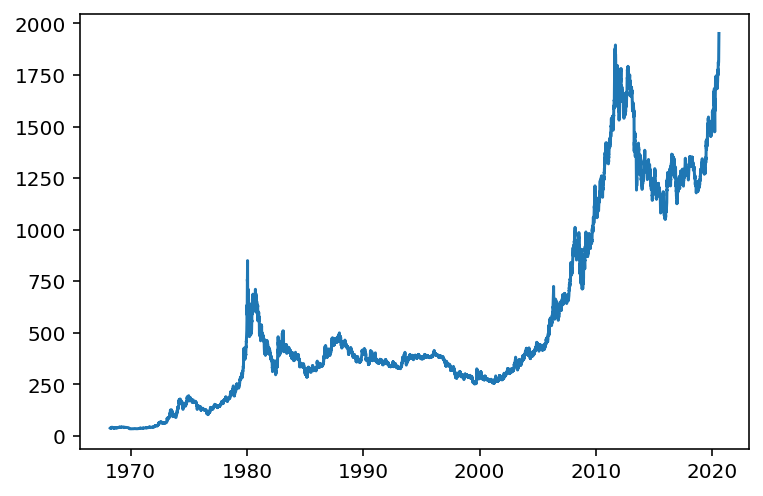

In [30]:
# check data
plt.plot(gold_data);

<a id='sp'></a>
### Get S&P 500 data

In [80]:
# initiate yahoo financial with the ticker symbol
ticker = '^GSPC'
yahoo_financials = YahooFinancials(ticker)

In [81]:
# define the date range 
# this will return a dict so we filter it to get the data related to the prices
sp500 = yahoo_financials.get_historical_price_data(start_date='1968-04-01', end_date='2020-07-28', time_interval='daily')['^GSPC']['prices']

In [82]:
# first enty in the dict 
sp500[0]

{'date': -55243800,
 'high': 93.55000305175781,
 'low': 91.11000061035156,
 'open': 91.11000061035156,
 'close': 92.4800033569336,
 'volume': 17730000,
 'adjclose': 92.4800033569336,
 'formatted_date': '1968-04-01'}

In [83]:
# crat a for loop to get the desied data (data and price) in a list form
dates = []
adj_close = []

for x in range(len(sp500)):
    date = sp500[x]['formatted_date']
    value = sp500[x]['adjclose']
    
    dates.append(date)
    adj_close.append(value)

In [84]:
# make a dict from the lists to easily create a DataFrame
d = {'date' : dates, 'value' : adj_close}
sp_500 = pd.DataFrame(d)

In [85]:
# set the date to DateTime and as an index
sp_500['date'] = pd.to_datetime(sp_500['date'])
sp_500 = sp_500.set_index('date')

In [86]:
# save to csv
sp_500.to_csv('sp_500.csv')

In [87]:
sp_500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13170 entries, 1968-04-01 to 2020-07-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   13170 non-null  float64
dtypes: float64(1)
memory usage: 205.8 KB


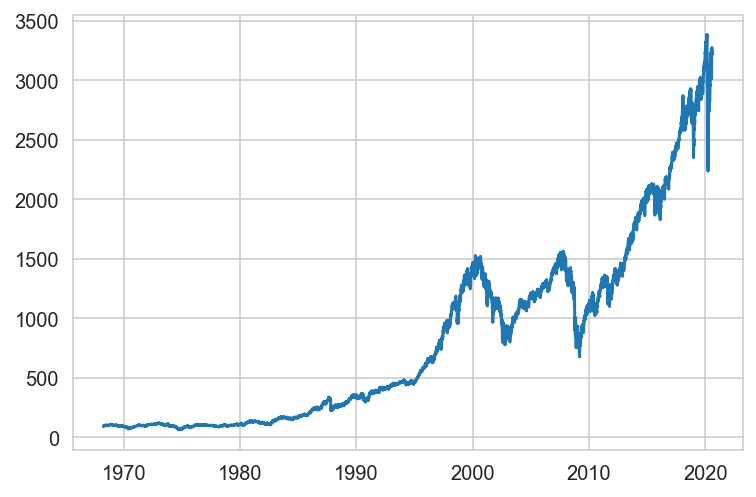

In [88]:
# check data
plt.plot(sp_500);

<a id='dates'></a>
### Find relevant dates
- lowest local low after the start 
- date where the price was higher than at the start date

In [2]:
# read in the data
# sp_500 = pd.read_csv('sp_500.csv')

In [3]:
# sp_500['date'] = pd.to_datetime(sp_500['date'])
# sp_500 = sp_500.set_index('date')

In [89]:
sp_500

,value
date,
1968-04-01,92.480003
1968-04-02,92.639999
1968-04-03,93.470001
1968-04-04,93.839996
1968-04-05,93.290001
...,...
2020-07-21,3257.300049
2020-07-22,3276.020020
2020-07-23,3235.659912


In [90]:
# function to find dates 
def find_date(df, start_date):
    '''
    function which finds the date of the next price higher than the start price and the date with the
    lowest price in that timeframe
    
    Input
        df: pandas DataFrame with the timeseries data, expects date as index with a column called value
        with the prices.
        start_date: start date of the crisis (yyyy-mm-dd).
    
    Returns
        tuple, wich includes:
            start_date
            end_date: date where the price is higher than the starting price
            min_date: date with the min price 
            df_range: pandas DataFrame with the prices 
    '''
    
    # make a new df with the strarting date to make the code simpler
    df_start = df.loc[start_date:]
    # transfom colum to uderlying nunpy array to find the fist value that is higher than the starting value
    df_list = df_start['value'].to_numpy()
    idx = np.argmax(df_list > df_list[0])
    # use the index of the higher price to find the date
    end_date = df_start.iloc[idx]
    end_date = end_date.name.strftime('%Y-%m-%d')
    
    # find global min price from start to end date
    # create full Dataframe
    df_range = df.loc[start_date:end_date]
    # find min price
    min_date = df_range[['value']].idxmin().value.strftime('%Y-%m-%d')
    
    #save the data in one tuple 
    data = start_date, end_date, min_date, df_range
    
    return data

In [91]:
# Test Function
values = find_date(sp_500, '2007-10-09')

In [92]:
#start date
values[0]

'2007-10-09'

In [93]:
# end date
values[1]

'2013-03-28'

In [94]:
# date with min price
values[2]

'2009-03-09'

In [95]:
# min price
values[3].loc['2009-03-09']

value    676.530029
Name: 2009-03-09 00:00:00, dtype: float64

#### Use function to find the relevant dates

In [96]:
# make a list with the starting dates 
staring_dates = ['11.05.1969', '02.01.1973', '24.11.1980', '17.08.1987', '20.03.2000', '09.10.2007']

In [97]:
dates_1970_energy = find_date(sp_500, '1968-11-29')
dates_1973_oil = find_date(sp_500, '1973-01-11')
dates_1980_recession = find_date(sp_500, '1980-11-28')
dates_Black_Monday = find_date(sp_500, '1987-08-25')
dates_Dotcombubble = find_date(sp_500, '2000-03-24')
dates_Financial_crisis = find_date(sp_500, '2007-10-09')

<a id='checkdates'></a>
#### Check dates

In [98]:
dates_1970_energy[0], dates_1970_energy[1],  dates_1970_energy[2]

('1968-11-29', '1972-03-06', '1970-05-26')

In [99]:
dates_1973_oil[0], dates_1973_oil[1], dates_1973_oil[2]

('1973-01-11', '1980-07-17', '1974-10-03')

In [100]:
dates_1980_recession[0], dates_1980_recession[1], dates_1980_recession[2]

('1980-11-28', '1982-11-03', '1982-08-12')

In [101]:
dates_Black_Monday[0], dates_Black_Monday[1], dates_Black_Monday[2]

('1987-08-25', '1989-07-26', '1987-12-04')

In [102]:
dates_Dotcombubble[0], dates_Dotcombubble[1], dates_Dotcombubble[2]

('2000-03-24', '2007-05-30', '2002-10-09')

In [103]:
dates_Financial_crisis[0], dates_Financial_crisis[1], dates_Financial_crisis[2]

('2007-10-09', '2013-03-28', '2009-03-09')

<a id='length'></a>
#### Length of the crises

lets check how many days a crisis usually lasts and the time range from high to low and high again. 

In [104]:
# test delta 
date_format = '%Y-%m-%d'
a = datetime.strptime('1968-11-29', date_format)
b = datetime.strptime('1972-03-06', date_format)
delta = b - a
print(delta.days)

1193


In [105]:
def get_range(data):
    '''
    Input
        data: Tuple with start date, end date, min price date and DataFrame
    '''
    # defina date format
    date_format = '%Y-%m-%d'
    #create dates
    start = datetime.strptime(data[0], date_format)
    end = datetime.strptime(data[1], date_format)
    low_date = datetime.strptime(data[2], date_format)
    
    #calculate deltas
    days_high_low = low_date - start
    days_low_high = end - low_date
    days_full = end - start
    
    return days_high_low.days, days_low_high.days, days_full.days

In [106]:
days = get_range(dates_Financial_crisis)

In [107]:
days

(517, 1480, 1997)

In [108]:
days_1970_energy = get_range(dates_1970_energy)
days_1973_oil = get_range(dates_1973_oil)
days_1980_recession = get_range(dates_1980_recession)
days_Black_Monday = get_range(dates_Black_Monday)
days_Dotcombubble = get_range(dates_Dotcombubble)
days_Financial_crisis = get_range(dates_Financial_crisis)

In [109]:
days_in_crisis = {'energy_crisis_1970': {'days_full': days_1970_energy[2], 'days_high_low': days_1970_energy[0], 'days_low_high': days_1970_energy[1]},
                  'oil_crisis_1973': {'days_full': days_1973_oil[2], 'days_high_low': days_1973_oil[0], 'days_low_high': days_1973_oil[1]},
                  'early_1980s_recession': {'days_full': days_1980_recession[2], 'days_high_low': days_1980_recession[0], 'days_low_high': days_1980_recession[1]},
                  'black_monday': {'days_full': days_Black_Monday[2], 'days_high_low': days_Black_Monday[0], 'days_low_high': days_Black_Monday[1]},
                  'dot_com_bubble': {'days_full': days_Dotcombubble[2], 'days_high_low': days_Dotcombubble[0], 'days_low_high': days_Dotcombubble[1]},
                  'financial_crisis_2007': {'days_full': days_Financial_crisis[2], 'days_high_low': days_Financial_crisis[0], 'days_low_high': days_Financial_crisis[1]}
                 }

In [110]:
days_in_crisis

{'energy_crisis_1970': {'days_full': 1193,
  'days_high_low': 543,
  'days_low_high': 650},
 'oil_crisis_1973': {'days_full': 2744,
  'days_high_low': 630,
  'days_low_high': 2114},
 'early_1980s_recession': {'days_full': 705,
  'days_high_low': 622,
  'days_low_high': 83},
 'black_monday': {'days_full': 701,
  'days_high_low': 101,
  'days_low_high': 600},
 'dot_com_bubble': {'days_full': 2623,
  'days_high_low': 929,
  'days_low_high': 1694},
 'financial_crisis_2007': {'days_full': 1997,
  'days_high_low': 517,
  'days_low_high': 1480}}

In [111]:
df_days_in_crisis = pd.DataFrame.from_dict(days_in_crisis, orient='index')

In [112]:
df_days_in_crisis.describe()

,days_full,days_high_low,days_low_high
count,6.000000,6.000000,6.00000
mean,1660.500000,557.000000,1103.50000
std,923.665253,267.458408,776.16332
min,701.000000,101.000000,83.00000
25%,827.000000,523.500000,612.50000
50%,1595.000000,582.500000,1065.00000
75%,2466.500000,628.000000,1640.50000
max,2744.000000,929.000000,2114.00000


In [113]:
# based on the distibution I will have to look at the median 
df_days_in_crisis[['days_full', 'days_high_low', 'days_low_high']].median()

days_full        1595.0
days_high_low     582.5
days_low_high    1065.0
dtype: float64

<a id='first'></a>
### Conclusion 
- the average number of days (median) between the <b>high before a crisis and a new high</b> is 1595 days (min:701 / max:2744)
- the average number of days (median) between the <b>high before the crisis and the global low during the crisis</b> is 583 days (min:101 / max:929)
- the average number of days (median) between the <b>low during the crisis ans the new high</b> is 1065 days (min:83 / max: 83)

<a id='createdf'></a>
### Create DataFrames for each crisis
1. Filter the main DF with the dates 
2. Calculate cumulative ptc change 

In [114]:
dates_list = [dates_1970_energy, dates_1973_oil, dates_1980_recession, dates_Black_Monday, dates_Dotcombubble, dates_Financial_crisis]
dates_name_list = ['dates_1970_energy', 'dates_1973_oil', 'dates_1980_recession', 'dates_Black_Monday', 'dates_Dotcombubble', 'dates_Financial_crisis']

In [115]:
for date, date_name in zip(dates_list, dates_name_list):
    print(f'{date_name}= stat date:{date[0]}, end date:{date[1]} and date with the lowest price:{date[2]}')

dates_1970_energy= stat date:1968-11-29, end date:1972-03-06 and date with the lowest price:1970-05-26
dates_1973_oil= stat date:1973-01-11, end date:1980-07-17 and date with the lowest price:1974-10-03
dates_1980_recession= stat date:1980-11-28, end date:1982-11-03 and date with the lowest price:1982-08-12
dates_Black_Monday= stat date:1987-08-25, end date:1989-07-26 and date with the lowest price:1987-12-04
dates_Dotcombubble= stat date:2000-03-24, end date:2007-05-30 and date with the lowest price:2002-10-09
dates_Financial_crisis= stat date:2007-10-09, end date:2013-03-28 and date with the lowest price:2009-03-09


In [116]:
# 1970s energy crisis
energy_crisis_1970 = gold_data.loc[dates_1970_energy[0]:dates_1970_energy[1]]
sp_energy_crisis_1970 = sp_500.loc[dates_1970_energy[0]:dates_1970_energy[1]]

# 1973 oil crisis
oil_crisis_1973 = gold_data.loc[dates_1973_oil[0]:dates_1973_oil[1]]
sp_oil_crisis_1973 = sp_500.loc[dates_1973_oil[0]:dates_1973_oil[1]]

# Early 1980s recession:
early_1980s_recession = gold_data.loc[dates_1980_recession[0]:dates_1980_recession[1]]
sp_early_1980s_recession = sp_500.loc[dates_1980_recession[0]:dates_1980_recession[1]]

# Black Monday:
black_monday = gold_data.loc[dates_Black_Monday[0]:dates_Black_Monday[1]]
sp_black_monday = sp_500.loc[dates_Black_Monday[0]:dates_Black_Monday[1]]

# Dot-com bubble:
dot_com_bubble = gold_data.loc[dates_Dotcombubble[0]:dates_Dotcombubble[1]]
sp_dot_com_bubble = sp_500.loc[dates_Dotcombubble[0]:dates_Dotcombubble[1]]

# Financial crisis of 2007–08:
financial_crisis_2007 = gold_data.loc[dates_Financial_crisis[0]:dates_Financial_crisis[1]]
sp_financial_crisis_2007 = sp_500.loc[dates_Financial_crisis[0]:dates_Financial_crisis[1]]

# Corona (2020): 10.02.2020 - till now (29.07.2020)
corona_2020 = gold_data.loc['2020-02-10':'2020-07-28']
sp_corona_2020 = sp_500.loc['2020-02-10':'2020-07-28']

In [117]:
# calculate cumulative ptc change for each crisis
energy_crisis_1970['sum_ptc_change_g'] = energy_crisis_1970['USD (PM)'].pct_change().cumsum()
sp_energy_crisis_1970['sum_ptc_change_sp'] = sp_energy_crisis_1970['value'].pct_change().cumsum()

oil_crisis_1973['sum_ptc_change_g'] = oil_crisis_1973['USD (PM)'].pct_change().cumsum()
sp_oil_crisis_1973['sum_ptc_change_sp'] = sp_oil_crisis_1973['value'].pct_change().cumsum()

early_1980s_recession['sum_ptc_change_g'] = early_1980s_recession['USD (PM)'].pct_change().cumsum()
sp_early_1980s_recession['sum_ptc_change_sp'] = sp_early_1980s_recession['value'].pct_change().cumsum()

black_monday['sum_ptc_change_g'] = black_monday['USD (PM)'].pct_change().cumsum()
sp_black_monday['sum_ptc_change_sp'] = sp_black_monday['value'].pct_change().cumsum()

dot_com_bubble['sum_ptc_change_g'] = dot_com_bubble['USD (PM)'].pct_change().cumsum()
sp_dot_com_bubble['sum_ptc_change_sp'] = sp_dot_com_bubble['value'].pct_change().cumsum()

financial_crisis_2007['sum_ptc_change_g'] = financial_crisis_2007['USD (PM)'].pct_change().cumsum()
sp_financial_crisis_2007['sum_ptc_change_sp'] = sp_financial_crisis_2007['value'].pct_change().cumsum()

corona_2020['sum_ptc_change_g'] = corona_2020['USD (PM)'].pct_change().cumsum()
sp_corona_2020['sum_ptc_change_sp'] = sp_corona_2020['value'].pct_change().cumsum()

<a id='join'></a>
#### Join Gold and S&P 500 DataFrames

- <b>merge</b> is an inner join by default
- <b>join</b> is a left join by default
- <b>concat</b> is an outer join by default

We need to make an inner join because the dates in the timeframe aren't equal and therefore days befor and during the crisis wouldn't add up in the visualization.

In [118]:
# join DataFrames with Gold and S&P 500 values on the Datetimeindex
energy_crisis_1970 = pd.merge(energy_crisis_1970, sp_energy_crisis_1970, left_index=True, right_index=True)
oil_crisis_1973 = pd.merge(oil_crisis_1973, sp_oil_crisis_1973, left_index=True, right_index=True)
early_1980s_recession = pd.merge(early_1980s_recession, sp_early_1980s_recession, left_index=True, right_index=True)
black_monday = pd.merge(black_monday, sp_black_monday, left_index=True, right_index=True)
dot_com_bubble = pd.merge(dot_com_bubble, sp_dot_com_bubble, left_index=True, right_index=True)
financial_crisis_2007 = pd.merge(financial_crisis_2007, sp_financial_crisis_2007, left_index=True, right_index=True)
corona_2020 = pd.merge(corona_2020, sp_corona_2020, left_index=True, right_index=True)

In [119]:
# create days from top
energy_crisis_1970['days_in_crisis'] = np.arange(0,len(energy_crisis_1970), 1)
oil_crisis_1973['days_in_crisis'] = np.arange(0,len(oil_crisis_1973), 1)
early_1980s_recession['days_in_crisis'] = np.arange(0,len(early_1980s_recession), 1)
black_monday['days_in_crisis'] = np.arange(0,len(black_monday), 1)
dot_com_bubble['days_in_crisis'] = np.arange(0,len(dot_com_bubble), 1)
financial_crisis_2007['days_in_crisis'] = np.arange(0,len(financial_crisis_2007), 1)
corona_2020['days_in_crisis'] = np.arange(0,len(corona_2020), 1)

In [120]:
# create function to get the gold prices before the crisis
def p_crisis(df_gold, df_sp, from_date, d):
    '''
    df_gold = DataFrame with Gold prices
    df_sp = DataFrame with S&P prices
    from_date = Date from which we start counting back
    d = how many days
    '''
    
    # claculate the start day for a period of x days
    end = datetime.strptime(from_date, '%Y-%m-%d')
    start = end - pd.offsets.Day(d)
    # inspired by https://stackoverflow.com/questions/40192704/filter-pandas-dataframe-for-past-x-days
    
    # create the DataFrame with the dates
    df_gold = df_gold.loc[start:from_date]
    df_sp = df_sp.loc[start:from_date]
    
    # sort the index to calculate cumulative sum
    df_gold.sort_index(ascending = False, inplace = True)
    df_gold['sum_ptc_change_g'] = df_gold['USD (PM)'].pct_change().cumsum()
    
    df_sp.sort_index(ascending = False, inplace = True)
    df_sp['sum_ptc_change_sp'] = df_sp['value'].pct_change().cumsum()
    
    # join DataFrames on DateTimeIndex
    df = pd.merge(df_gold, df_sp, left_index=True, right_index=True)
    
    # create days in crisis
    df['days_in_crisis'] = np.arange(0,-len(df), -1)
    
    # redo sort index 
    df.sort_index(ascending = True, inplace = True)
    
    # exclude the last row because it would be dublicated by appending the DataFrames
    df = df.iloc[:-1]
    
    return df

In [121]:
# create the DataFrame with 
p_1970 = p_crisis(gold_data, sp_500, dates_1970_energy[0], 100)
p_1973 = p_crisis(gold_data, sp_500, dates_1973_oil[0], 100)
p_1980 = p_crisis(gold_data, sp_500, dates_1980_recession[0], 100)
p_1987 = p_crisis(gold_data, sp_500, dates_Black_Monday[0], 100)
p_2000 = p_crisis(gold_data, sp_500, dates_Dotcombubble[0], 100)
p_2007 = p_crisis(gold_data, sp_500, dates_Financial_crisis[0], 100)
p_2020 = p_crisis(gold_data, sp_500, '2020-02-10', 100)

In [122]:
# function to append DataFrames
def append_DataFrame(p_df, c_df):
    '''
    p_df = DataFrame containing the prices prio crisis 
    c_df = DataFrame containign the prices in the crisis    
    '''
    df = p_df.append(c_df)
    return df

In [123]:
# create the finale DataFrame with the data before and during the crisis
energy_crisis_1970 = append_DataFrame(p_1970, energy_crisis_1970)
oil_crisis_1973 = append_DataFrame(p_1973, oil_crisis_1973)
early_1980s_recession = append_DataFrame(p_1980, early_1980s_recession)
black_monday = append_DataFrame(p_1987, black_monday)
dot_com_bubble = append_DataFrame(p_2000, dot_com_bubble)
financial_crisis_2007 = append_DataFrame(p_2007, financial_crisis_2007)
corona_2020 = append_DataFrame(p_2020, corona_2020)

<a id='chart'></a>
#### Create the chart

In [124]:
# set the style to give the chart a grid
sns.set_style('whitegrid')

In [153]:
ticks = np.arange(-0.75, 1.50, 0.25)
tick_names = ['-75%', '-50%', '-25%', '0%', '+25%', '+50%', '+75%', '+100%', '+125%']

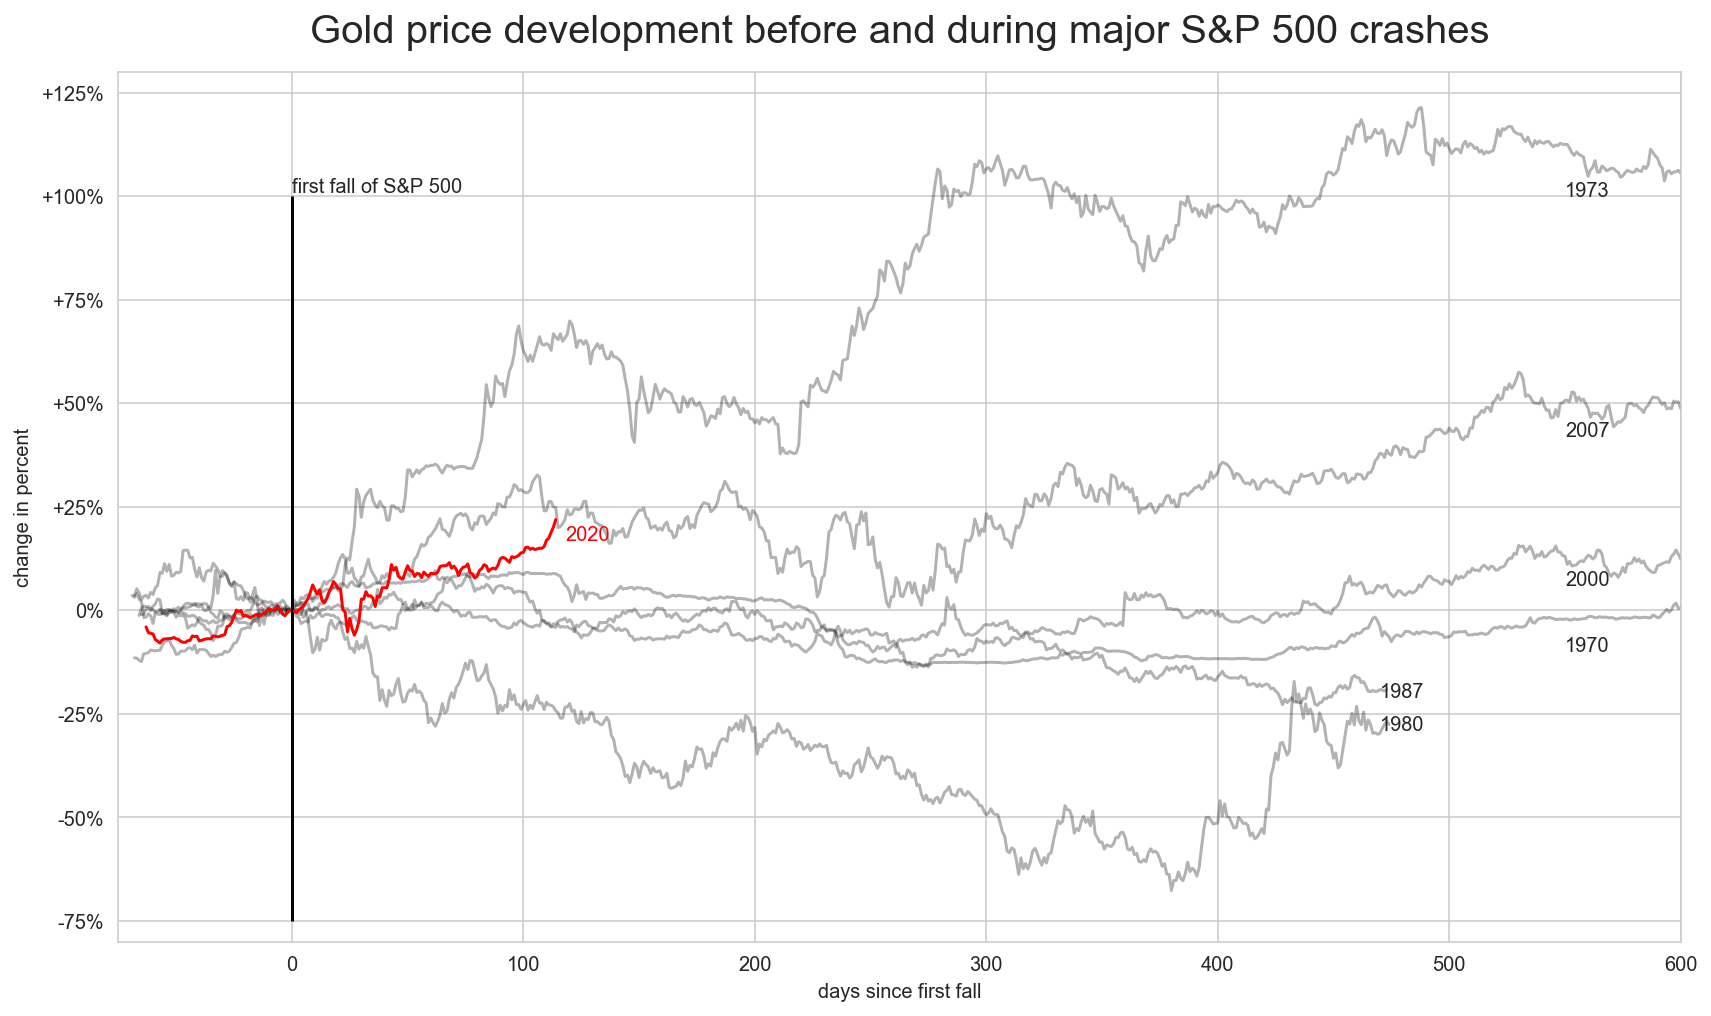

In [154]:
plt.subplots(figsize=(14,8))

plt.plot(energy_crisis_1970['days_in_crisis'], energy_crisis_1970['sum_ptc_change_g'], label='1970', color='k', alpha=0.3)
plt.plot(oil_crisis_1973['days_in_crisis'], oil_crisis_1973['sum_ptc_change_g'], label='1973', color='k', alpha=0.3)
plt.plot(early_1980s_recession['days_in_crisis'], early_1980s_recession['sum_ptc_change_g'], label='1980', color='k', alpha=0.3)
plt.plot(black_monday['days_in_crisis'], black_monday['sum_ptc_change_g'], label='1987', color='k', alpha=0.3)
plt.plot(dot_com_bubble['days_in_crisis'], dot_com_bubble['sum_ptc_change_g'], label='2000', color='k', alpha=0.3)
plt.plot(financial_crisis_2007['days_in_crisis'], financial_crisis_2007['sum_ptc_change_g'], label='2007', color='k', alpha=0.3)
plt.plot(corona_2020['days_in_crisis'], corona_2020['sum_ptc_change_g'], label='2020', color='r')

plt.annotate('1970', xy=(550, -0.1))
plt.annotate('1973', xy=(550, 1))
plt.annotate('1980', xy=(470, -0.29))
plt.annotate('1987', xy=(470, -0.21))
plt.annotate('2000', xy=(550, 0.06))
plt.annotate('2007', xy=(550, 0.42))
plt.annotate('2020', xy=(118, 0.17), color='r')

plt.vlines(0, colors='k', ymin=-0.75, ymax=1)
plt.annotate('first fall of S&P 500', xy=(0, 1.01))

plt.xlim(-75,600)
plt.ylim(-0.80, 1.30)
plt.yticks(ticks, tick_names)
plt.title('Gold price development before and during major S&P 500 crashes', fontsize=20, pad=15)
plt.xlabel('days since first fall')
plt.ylabel('change in percent')
plt.savefig('Gold_price_development_during_crashes.png', dpi=300);

#### define function for one on one visualization

In [68]:
def one_one_plot(df, crisis_name):
    '''
    df= DataFrame for crisis
    crisis_name = name of the crisis
    '''
    
    plt.subplots(figsize=(12,6))
    
    plt.plot(df['days_in_crisis'], df['sum_ptc_change_g'], label = 'Gold', color = 'r')
    plt.plot(df['days_in_crisis'], df['sum_ptc_change_sp'], label = 'S&P 500', color = 'k', alpha = 0.3) 

    plt.vlines(0, colors='k', ymin=-0.75, ymax=1)
    plt.annotate('first fall of S&P 500', xy=(0, 1.01))

    plt.xlim(-75,len(df))
    plt.yticks(ticks, tick_names)
    plt.title(f'{crisis_name}: Gold and S&P 500 price development', fontsize=20, pad=15)
    plt.xlabel('days before and after the first fall of the S&P 500')
    plt.ylabel('change in percent')
    plt.legend();

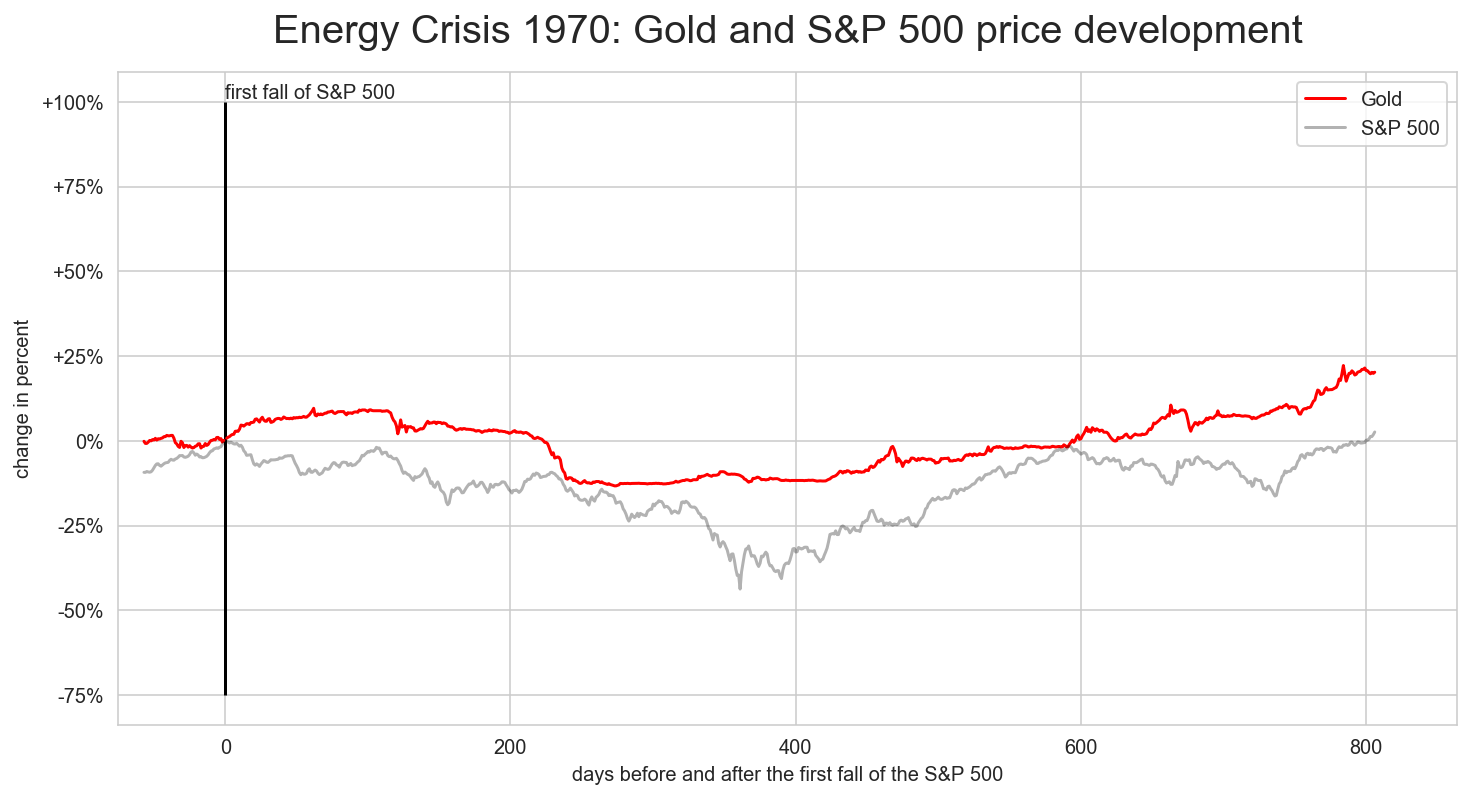

In [69]:
one_one_plot(energy_crisis_1970, 'Energy Crisis 1970')

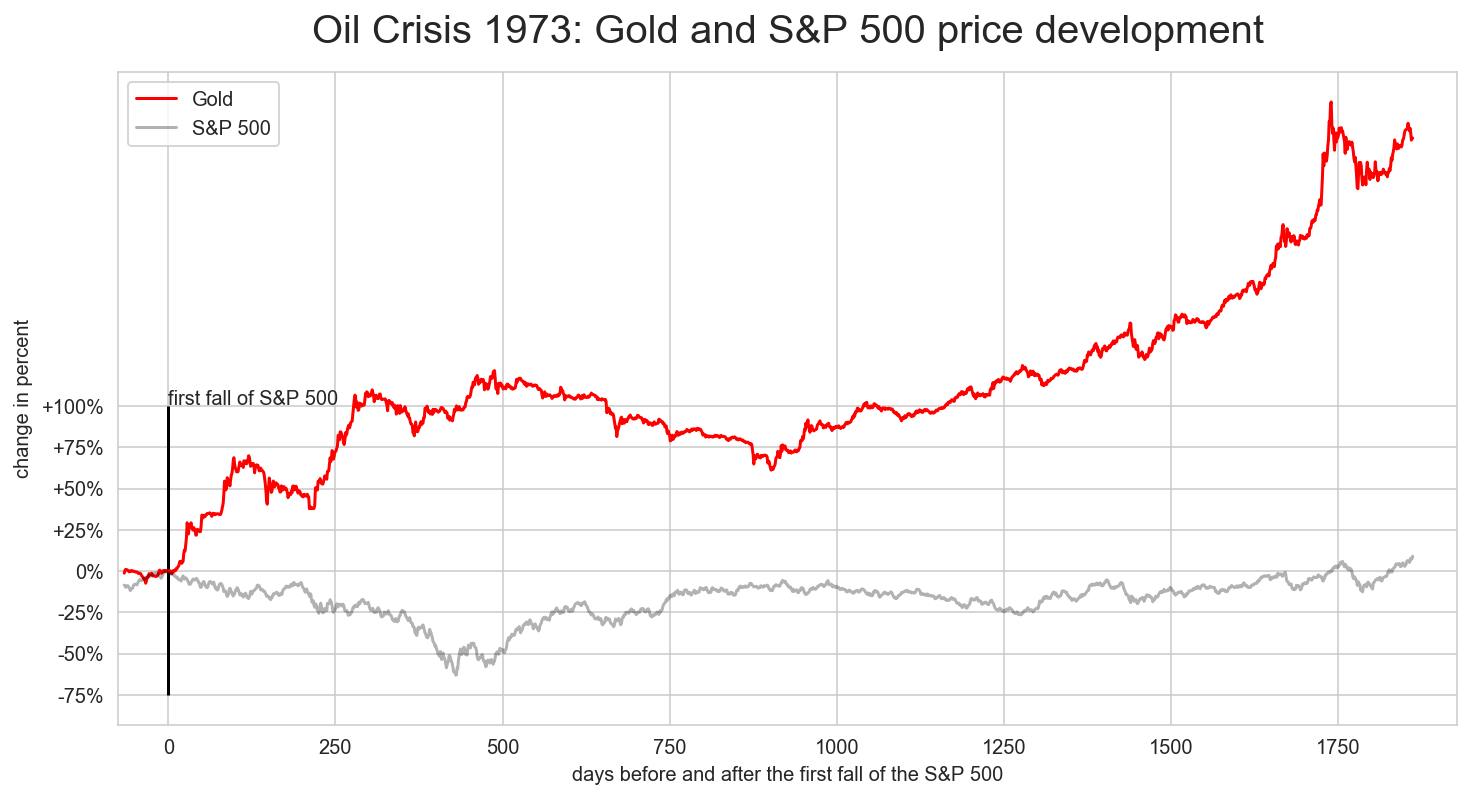

In [70]:
one_one_plot(oil_crisis_1973, 'Oil Crisis 1973')

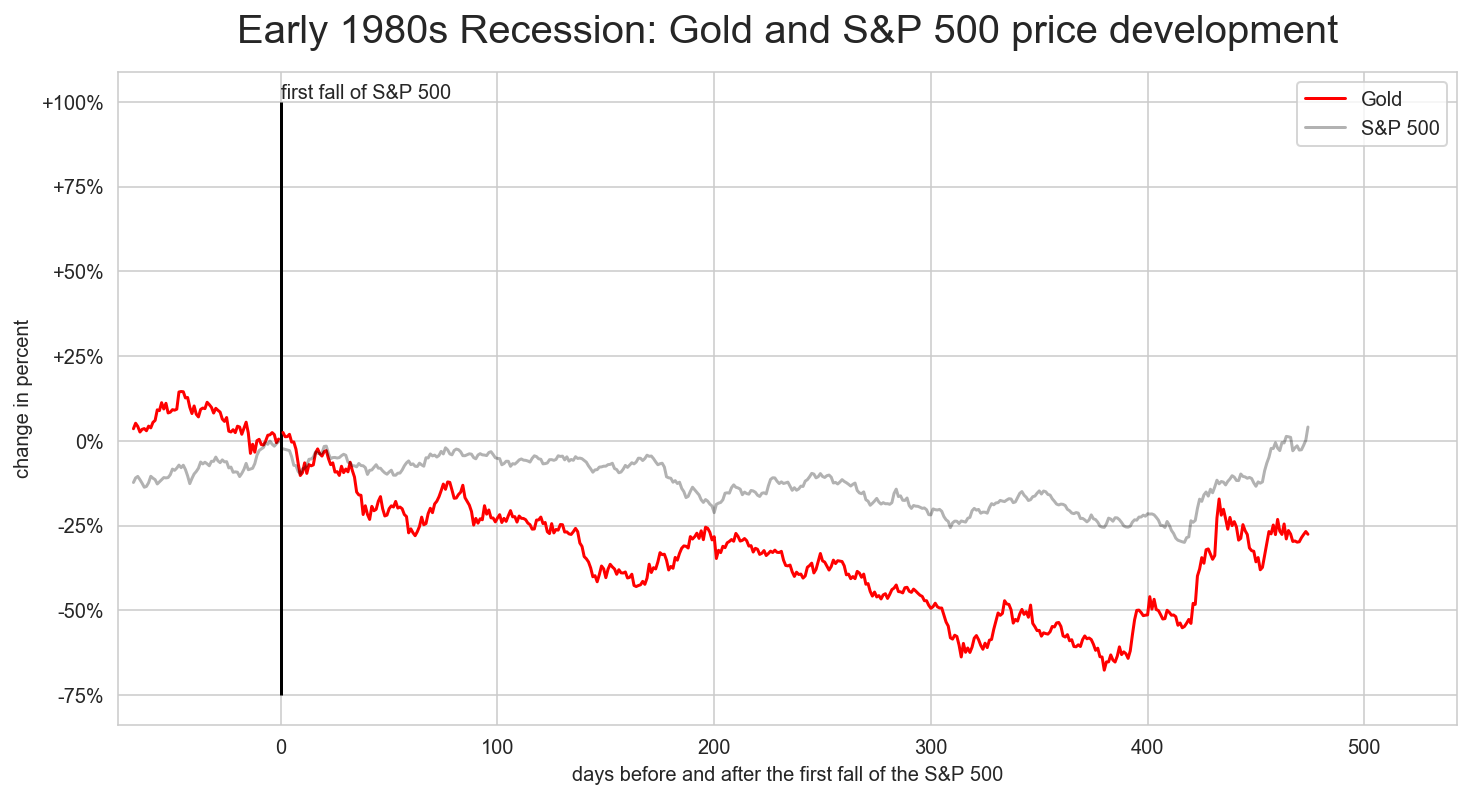

In [72]:
one_one_plot(early_1980s_recession, 'Early 1980s Recession')

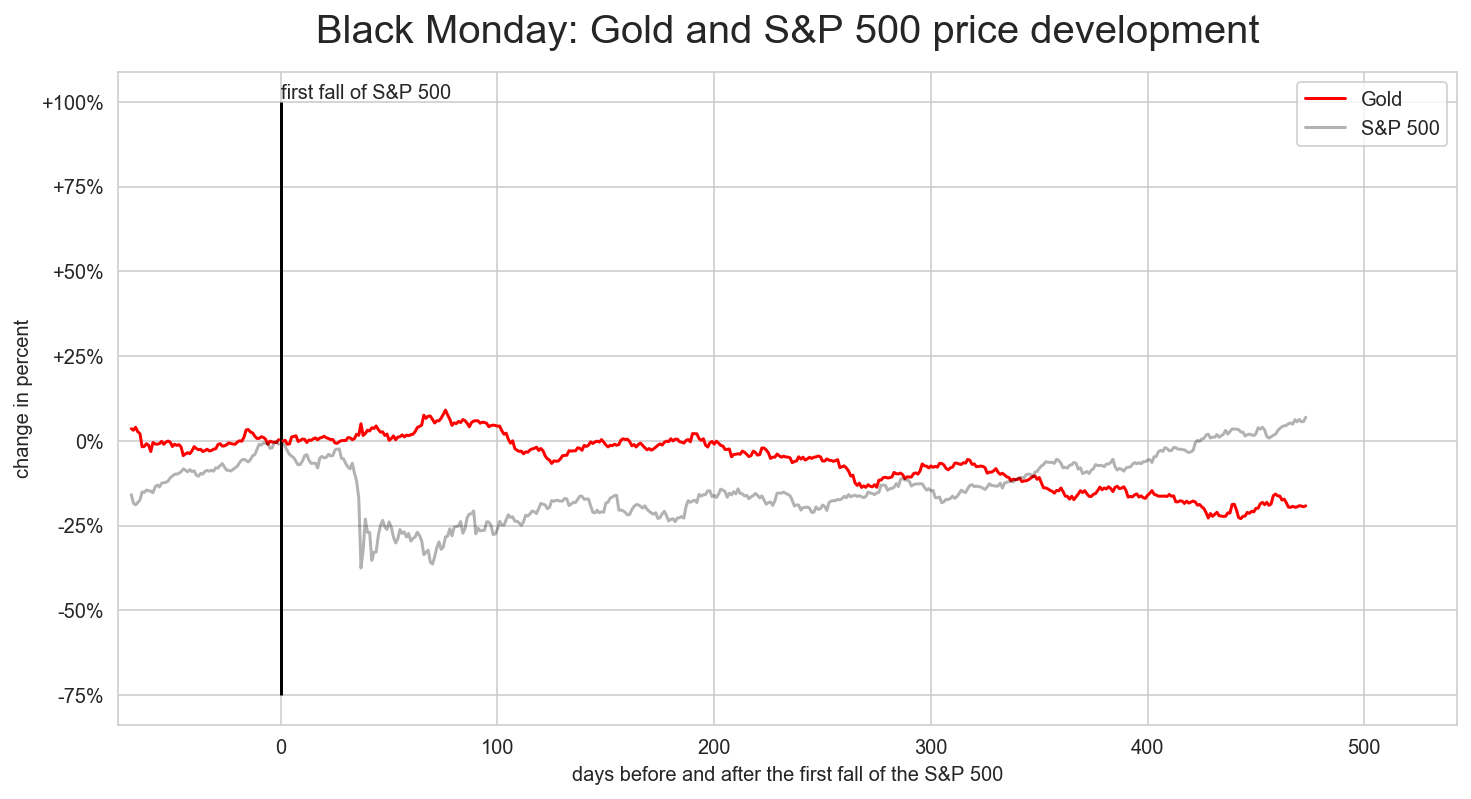

In [73]:
one_one_plot(black_monday, 'Black Monday')

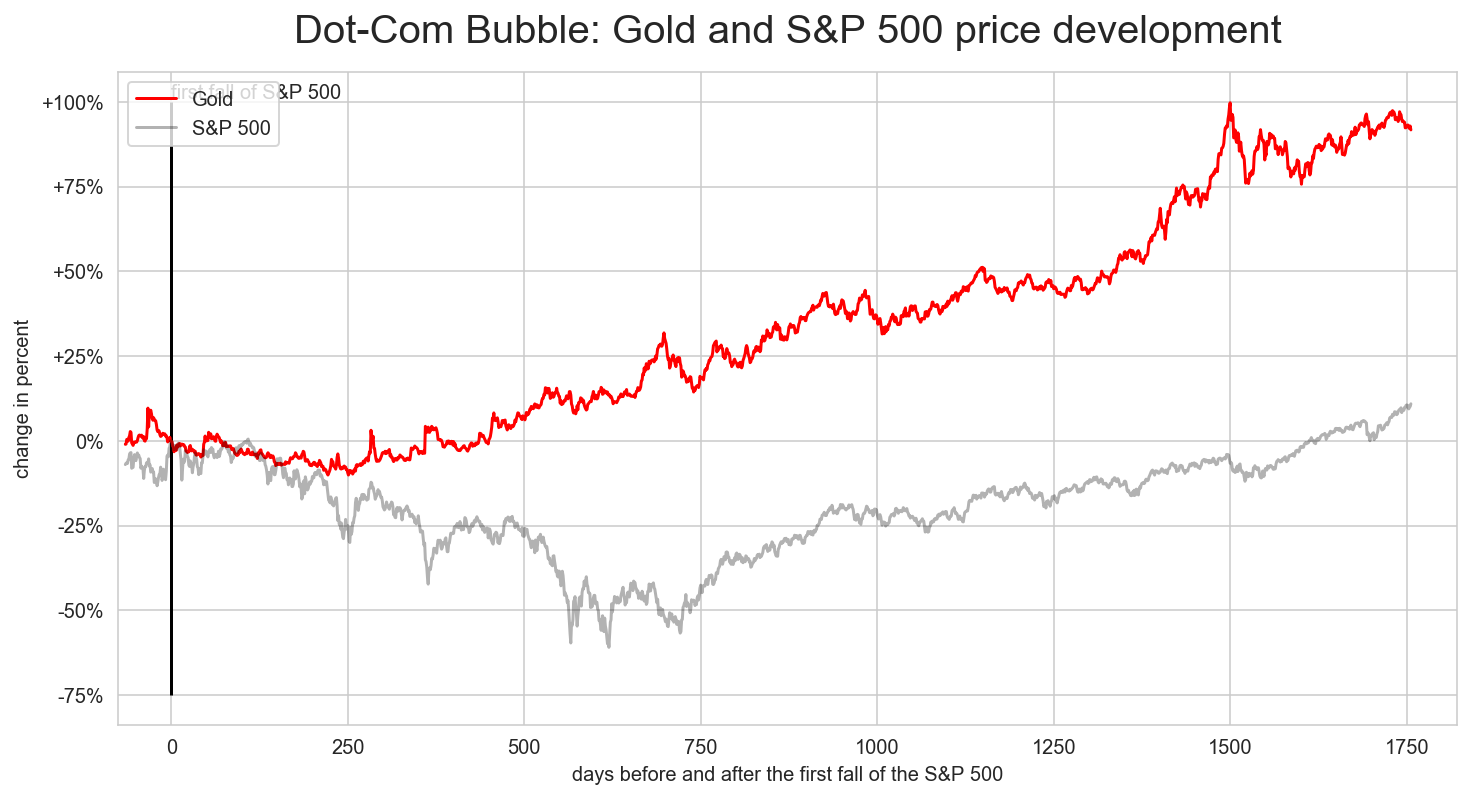

In [74]:
one_one_plot(dot_com_bubble, 'Dot-Com Bubble')

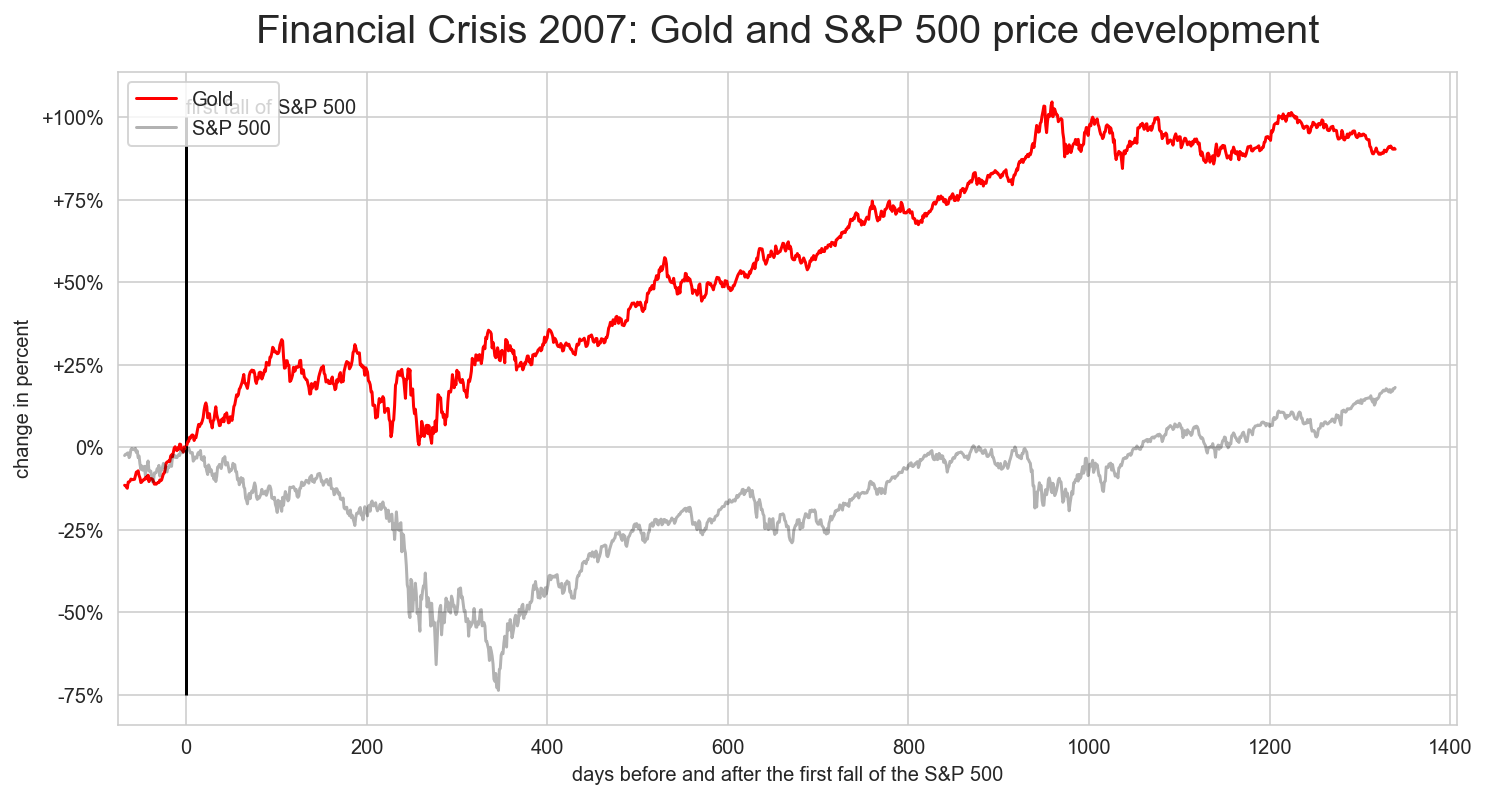

In [75]:
one_one_plot(financial_crisis_2007, 'Financial Crisis 2007')

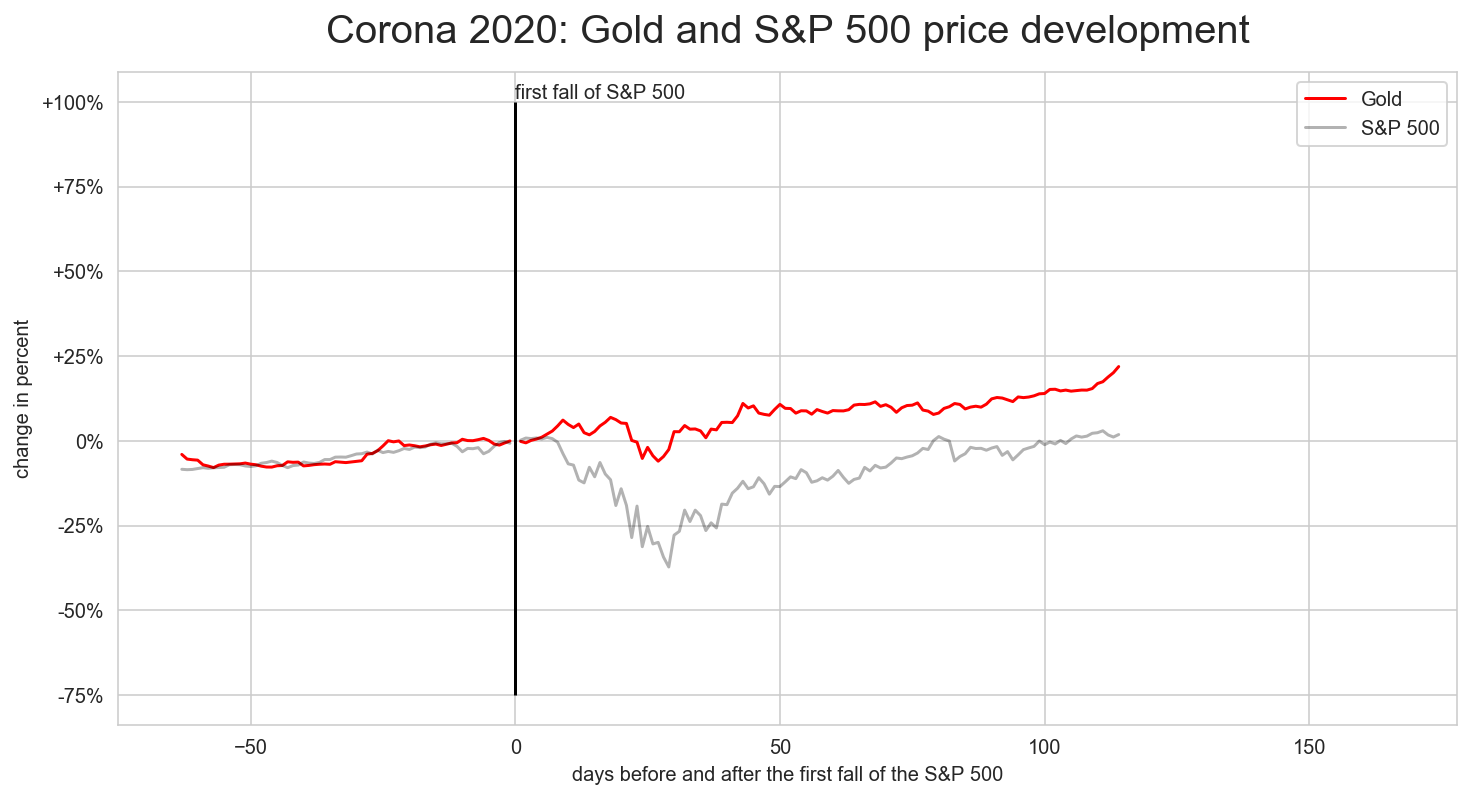

In [127]:
one_one_plot(corona_2020, 'Corona 2020')

<a id='max'></a>
### Calculating max percentage gain
to calculate the max percentage gain I need to remove the days before the start of the crisis. For that I can use the code from above, I just changed the name of the variable so that I don't overwrite the existing variables.

In [171]:
#1970s energy crisis
energy_crisis_1970_m = energy_crisis_1970.loc[dates_1970_energy[0]:dates_1970_energy[1]]

# 1973 oil crisis
oil_crisis_1973_m = oil_crisis_1973.loc[dates_1973_oil[0]:dates_1973_oil[1]]

# Early 1980s recession:
early_1980s_recession_m = early_1980s_recession.loc[dates_1980_recession[0]:dates_1980_recession[1]]

# Black Monday:
black_monday_m = black_monday.loc[dates_Black_Monday[0]:dates_Black_Monday[1]]

# Dot-com bubble:
dot_com_bubble_m = dot_com_bubble.loc[dates_Dotcombubble[0]:dates_Dotcombubble[1]]

# Financial crisis of 2007–08:
financial_crisis_2007_m = financial_crisis_2007.loc[dates_Financial_crisis[0]:dates_Financial_crisis[1]]

# Corona (2020): 10.02.2020 - till now (29.07.2020)
corona_2020_m = corona_2020.loc['2020-02-10':'2020-07-28']

In [180]:
df_final_list = [energy_crisis_1970_m, oil_crisis_1973_m, early_1980s_recession_m, black_monday_m,
                 dot_com_bubble_m, financial_crisis_2007_m, corona_2020_m]
df_final_names = ['energy_crisis_1970', 'oil_crisis_1973', 'early_1980s_recession', 'black_monday', 
                  'dot_com_bubble', 'financial_crisis_2007', 'corona_2020']

In [185]:
for df, df_name in zip(df_final_list, df_final_names):
    print(f'{df_name}: max gain = {df["sum_ptc_change_g"].max()}')

energy_crisis_1970: max gain = 0.22212769140096533
oil_crisis_1973: max gain = 2.8408811614777365
early_1980s_recession: max gain = 0.024606696248487214
black_monday: max gain = 0.09073347289382028
dot_com_bubble: max gain = 0.9975579565928062
financial_crisis_2007: max gain = 1.0463848789003465
corona_2020: max gain = 0.2191054864525801


In [189]:
for df, df_name in zip(df_final_list, df_final_names):
    print(f'{df_name}: max gain = {df["sum_ptc_change_g"].min()}')

energy_crisis_1970: max gain = -0.13301430570389572
oil_crisis_1973: max gain = -0.01743552801069459
early_1980s_recession: max gain = -0.6768550158849499
black_monday: max gain = -0.2298149847929758
dot_com_bubble: max gain = -0.10098624059320227
financial_crisis_2007: max gain = 0.007133152173913082
corona_2020: max gain = -0.06014084752219939


<a id='final'></a>
## Conclusion
To recap the questions of this analysis was: Gold is generally known as the safe haven for investors in such crises and is therefore the profiteer of uncertain times. But is this really the case?
- for the most time Gold price was higher as before, when the S&P reached the same price as before the crisis. Only in two instances gold   performed weaker than the S&P 500 (early 1980s recession, Black Monday)
- The highest gain was after the oil crisis in 1973 with a max gain of 284% based
- The biggest decrease in gold value during a crisis was -68% during the early 1980s recessions 


## Other Visualization Libs

### Plotly

In [25]:
# reset index
energy_crisis_1970.set_index('days_in_crisis', inplace = True)
oil_crisis_1973.set_index('days_in_crisis', inplace = True)
early_1980s_recession.set_index('days_in_crisis', inplace = True)
black_monday.set_index('days_in_crisis', inplace = True)
dot_com_bubble.set_index('days_in_crisis', inplace = True)
financial_crisis_2007.set_index('days_in_crisis', inplace = True)
corona_2020.set_index('days_in_crisis', inplace = True)

In [26]:
# drop unrelevnat columns
oil_crisis_1973 = oil_crisis_1973['sum_ptc_change_g']
energy_crisis_1970 = energy_crisis_1970['sum_ptc_change_g']
early_1980s_recession = early_1980s_recession['sum_ptc_change_g']
black_monday = black_monday['sum_ptc_change_g']
dot_com_bubble = dot_com_bubble['sum_ptc_change_g']
financial_crisis_2007 = financial_crisis_2007['sum_ptc_change_g']
corona_2020 = corona_2020['sum_ptc_change_g']

In [27]:
# concat
gold_crises = pd.concat([energy_crisis_1970, oil_crisis_1973, early_1980s_recession, black_monday, dot_com_bubble, financial_crisis_2007, corona_2020], axis=1)

In [28]:
col_names = ['energy_crisis_1970', 'oil_crisis_1973', 'early_1980s_recession', 'black_monday', 'dot_com_bubble', 
             'financial_crisis_2007', 'corona_2020']

In [29]:
gold_crises.columns = col_names

In [32]:
gold_crises.to_csv('data_plotly_vis.csv')

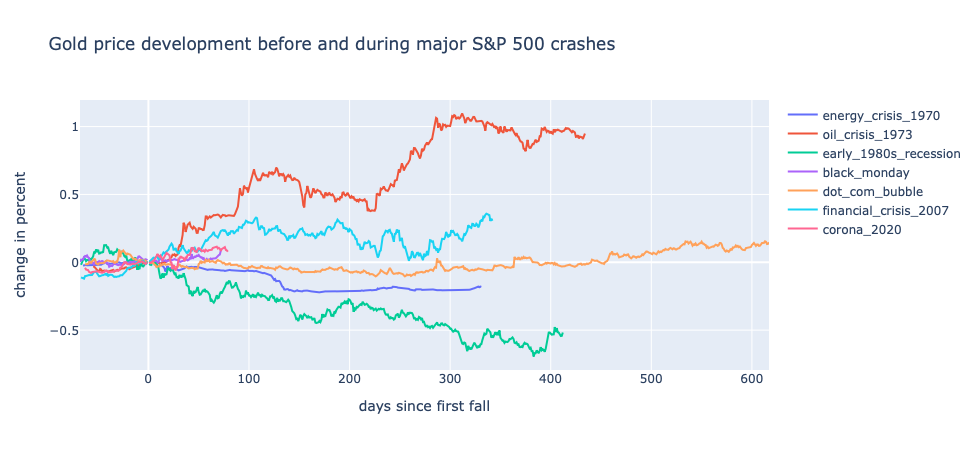

In [35]:
# cretae figure
fig = go.Figure()

# add traces for each crisis
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.energy_crisis_1970, mode='lines', name='energy_crisis_1970'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.oil_crisis_1973, mode='lines', name='oil_crisis_1973'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.early_1980s_recession, mode='lines', name='early_1980s_recession'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.black_monday, mode='lines', name='black_monday'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.dot_com_bubble, mode='lines', name='dot_com_bubble'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.financial_crisis_2007, mode='lines', name='financial_crisis_2007'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.corona_2020, mode='lines', name='corona_2020'))

# change layout
fig.update_layout(title='Gold price development before and during major S&P 500 crashes',
                   xaxis_title='days since first fall',
                   yaxis_title='change in percent')

# sets hovermode to compare data points
fig.layout.hovermode = 'x'
fig.show()

## Resources
- https://www.quandl.com/data/LBMA-London-Bullion-Market-Association
- https://finance.yahoo.com/quote/%5EGSPC/
- https://stackoverflow.com/questions/35090498/how-to-calculate-percent-change-compared-to-the-beginning-value-using-pandas
- https://stackoverflow.com/questions/151199/how-to-calculate-number-of-days-between-two-given-dates
- https://www.programiz.com/python-programming/nested-dictionary
- https://stackoverflow.com/questions/18648626/for-loop-with-two-variables